**Importing Libraries**


In [2]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import callbacks
from keras.models import Model
import efficientnet.keras as efn
from keras.preprocessing.image import ImageDataGenerator


import glob
import cv2

tf.random.set_seed(42)

import warnings
warnings.filterwarnings('ignore')

**Linking to my google drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Defining Variables**

In [5]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

**Loading the data and forming dataframes**

In [6]:
main_path = "/content/drive/MyDrive/Data/chest_xray"

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


In [7]:
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [ ]:
df_train

,class,image
0,Normal,/content/drive/MyDrive/Data/chest_xray/train/NORMAL/NORMAL-3260755-0001.jpeg
1,Normal,/content/drive/MyDrive/Data/chest_xray/train/NORMAL/NORMAL-3399582-0001.jpeg
2,Normal,/content/drive/MyDrive/Data/chest_xray/train/NORMAL/NORMAL-324309-0001.jpeg
3,Normal,/content/drive/MyDrive/Data/chest_xray/train/NORMAL/NORMAL-339692-0002.jpeg
4,Normal,/content/drive/MyDrive/Data/chest_xray/train/NORMAL/NORMAL-3371493-0001.jpeg
...,...,...
5227,Pneumonia,/content/drive/MyDrive/Data/chest_xray/train/PNEUMONIA/BACTERIA-417263-0005.jpeg
5228,Pneumonia,/content/drive/MyDrive/Data/chest_xray/train/PNEUMONIA/BACTERIA-4214872-0001.jpeg
5229,Pneumonia,/content/drive/MyDrive/Data/chest_xray/train/PNEUMONIA/BACTERIA-4198099-0001.jpeg
5230,Pneumonia,/content/drive/MyDrive/Data/chest_xray/train/PNEUMONIA/BACTERIA-4163667-0001.jpeg


In [ ]:
df_test

,class,image
0,Normal,/content/drive/MyDrive/Data/chest_xray/test/NORMAL/NORMAL-1759114-0001.jpeg
1,Normal,/content/drive/MyDrive/Data/chest_xray/test/NORMAL/NORMAL-1283091-0001.jpeg
2,Normal,/content/drive/MyDrive/Data/chest_xray/test/NORMAL/NORMAL-1627110-0001.jpeg
3,Normal,/content/drive/MyDrive/Data/chest_xray/test/NORMAL/NORMAL-1784004-0001.jpeg
4,Normal,/content/drive/MyDrive/Data/chest_xray/test/NORMAL/NORMAL-1318320-0001.jpeg
...,...,...
619,Pneumonia,/content/drive/MyDrive/Data/chest_xray/test/PNEUMONIA/VIRUS-9783315-0001.jpeg
620,Pneumonia,/content/drive/MyDrive/Data/chest_xray/test/PNEUMONIA/VIRUS-8507816-0001.jpeg
621,Pneumonia,/content/drive/MyDrive/Data/chest_xray/test/PNEUMONIA/VIRUS-8544560-0001.jpeg
622,Pneumonia,/content/drive/MyDrive/Data/chest_xray/test/PNEUMONIA/VIRUS-9968655-0001.jpeg


**Exploring the data**

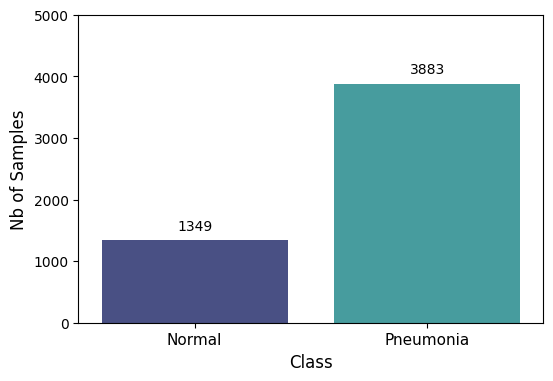

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("Nb of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

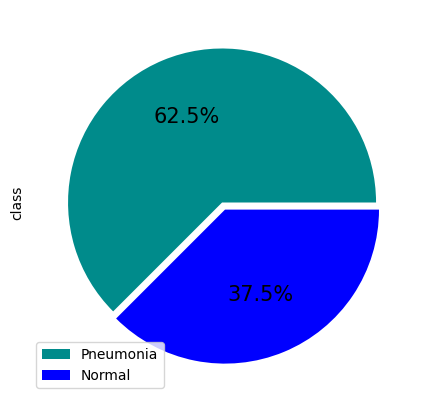

In [ ]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.show()

**We can see that our training data is imbalanced. I will use data augmentation (ImageDataGenerator) to deal with the imbalanced data**

**Viewing a normal chest x-ray and a chest x-ray with Pneumonia**

Normal Chest X-ray: 



(-0.5, 223.5, 223.5, -0.5)

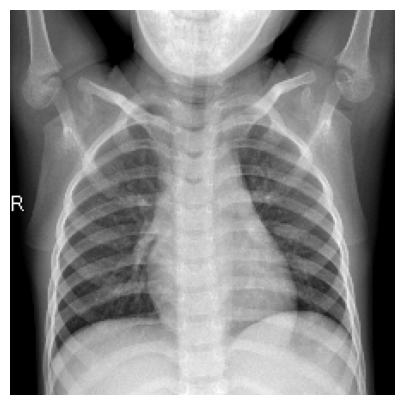

In [ ]:
print("Normal Chest X-ray: \n")

plt.figure(figsize = (5,5))
img = cv2.imread(train_normal[random.randint(0,len(train_normal)-1)])
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
plt.imshow(img)
plt.axis("off")


Chest X-ray with Pneumonia: 



(-0.5, 223.5, 223.5, -0.5)

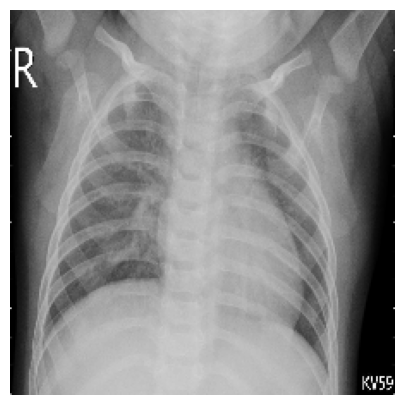

In [ ]:
print("Chest X-ray with Pneumonia: \n")

plt.figure(figsize = (5,5))
img = cv2.imread(train_pneumonia[random.randint(0,len(train_pneumonia)-1)])
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
plt.imshow(img)
plt.axis("off")

**Splitting the train data into train and validation**

In [8]:
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

**1. Loading the images to feed the model using flow_from_dataframe.**

**2. Using ImageDataGenerator to rescale the data and perform Data Augmentation to deal with the imbalancy.**
**I defined two different generators, val_datagen to simply rescale the validation and test sets and train_datagen which rescales and includes some transformations to augment the train set.**

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)


test_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             stratify=True,
                                             seed = SEED)


ds_val = train_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            stratify=True,
                                            seed = SEED)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


**Choosing the base model, I selected model EfficientNetB7.**

This model was already trained on another dataset (ImageNet). We set include_top to false, removing the ‘head’. The head layer is responsible for performing the classification or regression task that the network was designed for. We keep all the previous layers. Then, we include our last few layers, including the one responsible for generating the output.

In [10]:
base_model = efn.EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = 'imagenet')

258434480/258434480 [==============================] - 7s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
# defining our input layer shape
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# using the pre-trained weights of the base_model as a starting point
x = base_model(inputs)

# Head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.1)(x)

# Final Layer (Output)
prediction = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=prediction)

In [13]:
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnet-b7 (Functional  (None, 7, 7, 2560)       64097680  
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               327808    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129   

In [ ]:
# keras.backend.clear_session()

**Defining Early_Stopping and Plateau**

- Early stopping is a technique used to prevent overfitting. It involves monitoring the performance of the model on a validation set during training and stopping the training process when the performance on the validation set stops improving.

- ReduceLROnPlateau is a callback function that reduces the learning rate when the specified metric stops improving for longer than the patience number allows. It is used to prevent the model from overfitting and to improve the accuracy of the model.

In [14]:
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,
    patience = 2,
    min_delt = 1e-7,
    cooldown = 0,
    verbose = 1
)

**Fitting the model**

In [ ]:
eff_history = model.fit_generator(ds_train,
          epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));


Epoch 1/3
130/130 [==============================] - 6208s 47s/step - loss: 0.3910 - accuracy: 0.8244 - val_loss: 0.2128 - val_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 2/3
130/130 [==============================] - 3288s 25s/step - loss: 0.2468 - accuracy: 0.8989 - val_loss: 0.1680 - val_accuracy: 0.9360 - lr: 1.0000e-04
Epoch 3/3
130/130 [==============================] - 3200s 25s/step - loss: 0.2255 - accuracy: 0.9070 - val_loss: 0.1666 - val_accuracy: 0.9408 - lr: 1.0000e-04


**Plotting the learning curve of Loss**

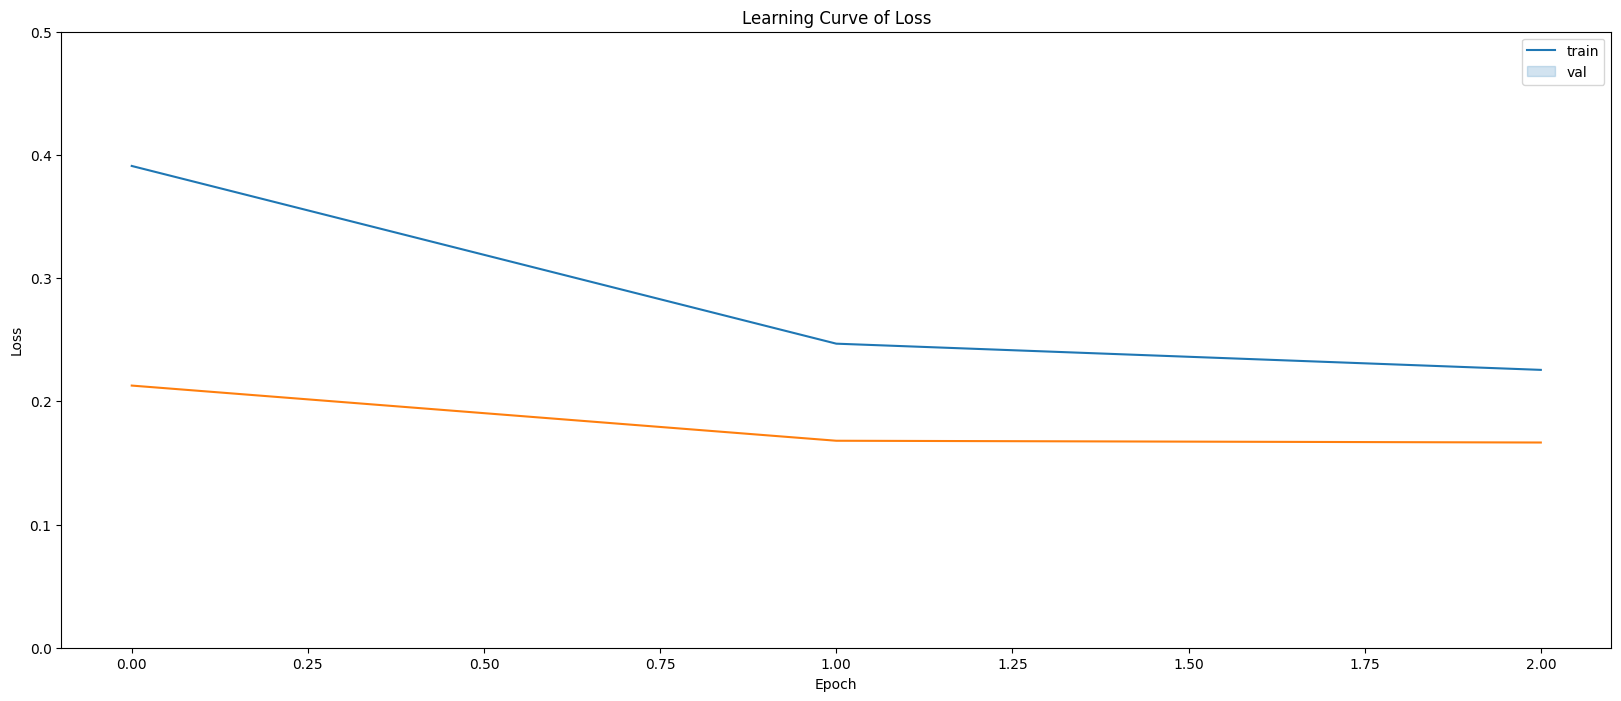

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = eff_history.epoch, y = eff_history.history['loss'])
sns.lineplot(x = eff_history.epoch, y = eff_history.history['val_loss'])
ax.set_title('Learning Curve of Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

**Plotting the learning curve of Accuracy**

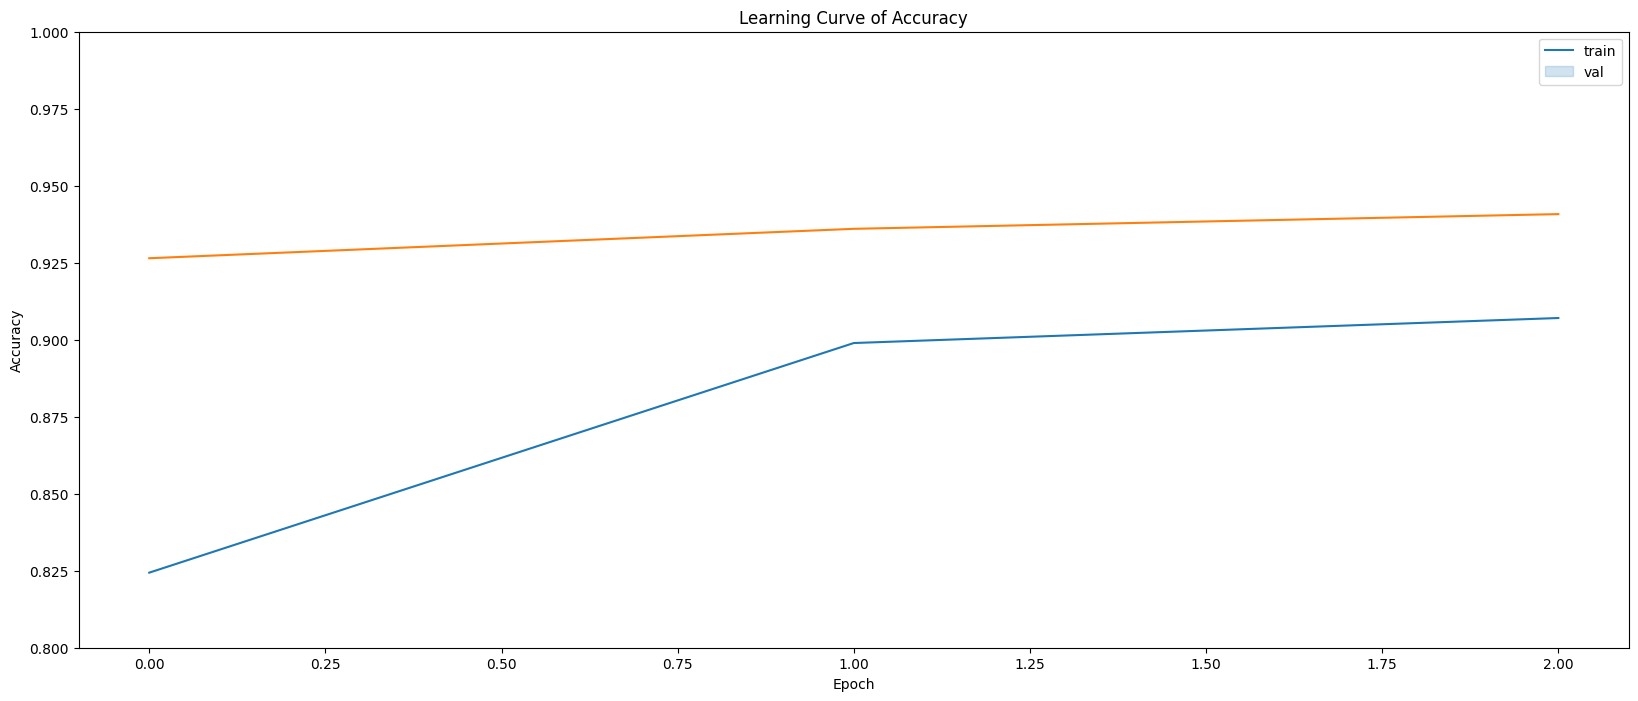

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = eff_history.epoch, y = eff_history.history['accuracy'])
sns.lineplot(x = eff_history.epoch, y = eff_history.history['val_accuracy'])
ax.set_title('Learning Curve of Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

**Checking Performance on Validation Set**

In [ ]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.16638942062854767
Val accuracy: 0.9360076189041138


**Checking Performance on Test Set**

In [ ]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1950341761112213
Test accuracy: 0.9471153616905212


**Plotting the confusion matrix and classification report**

In [ ]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [ ]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [ ]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9471153846153846


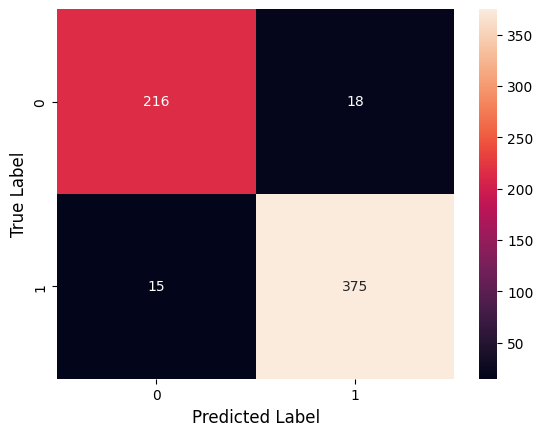

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [ ]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       234
           1       0.95      0.96      0.96       390

    accuracy                           0.95       624
   macro avg       0.94      0.94      0.94       624
weighted avg       0.95      0.95      0.95       624



**Saving the model**

In [ ]:
model.save('my_model.h5')

## **Fine Tuning the model:**

This is done by unfreezing a couple of the last layers in the pre-trained model so that the weights can be adjusted according to our dataset (images). Previously, we were only adjusting the weights of the "head" layer only.

In [11]:
base_model.trainable = True

# Freeze all layers except for last 20
for layer in base_model.layers[:-20]:
    layer.trainable = False

In [15]:
eff_history_tuned = model.fit_generator(ds_train,
          epochs = 3,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

Epoch 1/3
130/130 [==============================] - 6467s 49s/step - loss: 0.3359 - accuracy: 0.8562 - val_loss: 0.1460 - val_accuracy: 0.9503 - lr: 1.0000e-04
Epoch 2/3
130/130 [==============================] - 3623s 28s/step - loss: 0.2127 - accuracy: 0.9121 - val_loss: 0.1388 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 3/3
130/130 [==============================] - 3596s 28s/step - loss: 0.1853 - accuracy: 0.9233 - val_loss: 0.0951 - val_accuracy: 0.9685 - lr: 1.0000e-04


**Plotting the learning curve of Loss**

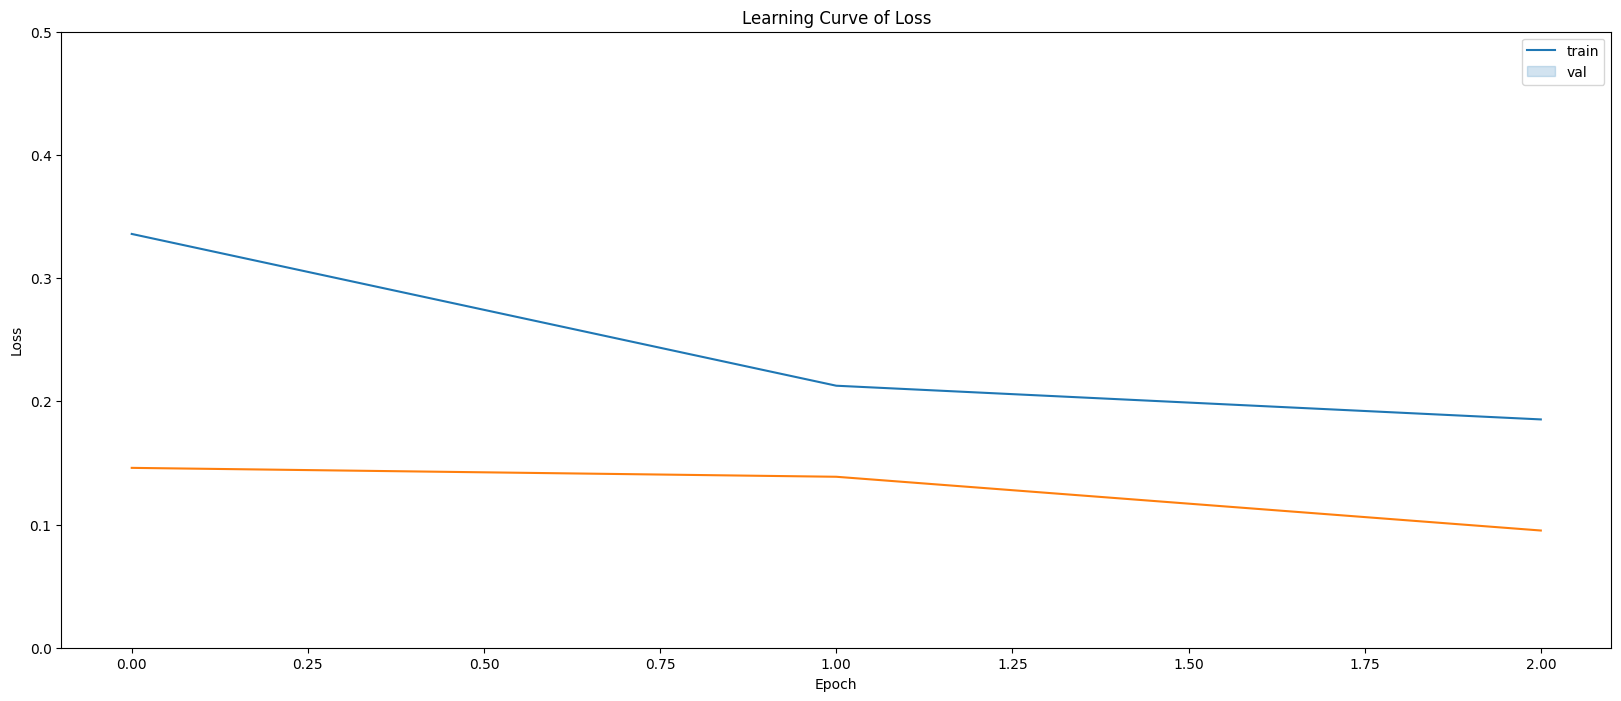

In [16]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = eff_history_tuned.epoch, y = eff_history_tuned.history['loss'])
sns.lineplot(x = eff_history_tuned.epoch, y = eff_history_tuned.history['val_loss'])
ax.set_title('Learning Curve of Loss')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.5)
ax.legend(['train', 'val'], loc='best')
plt.show()

**Plotting the learning curve of Accuracy**

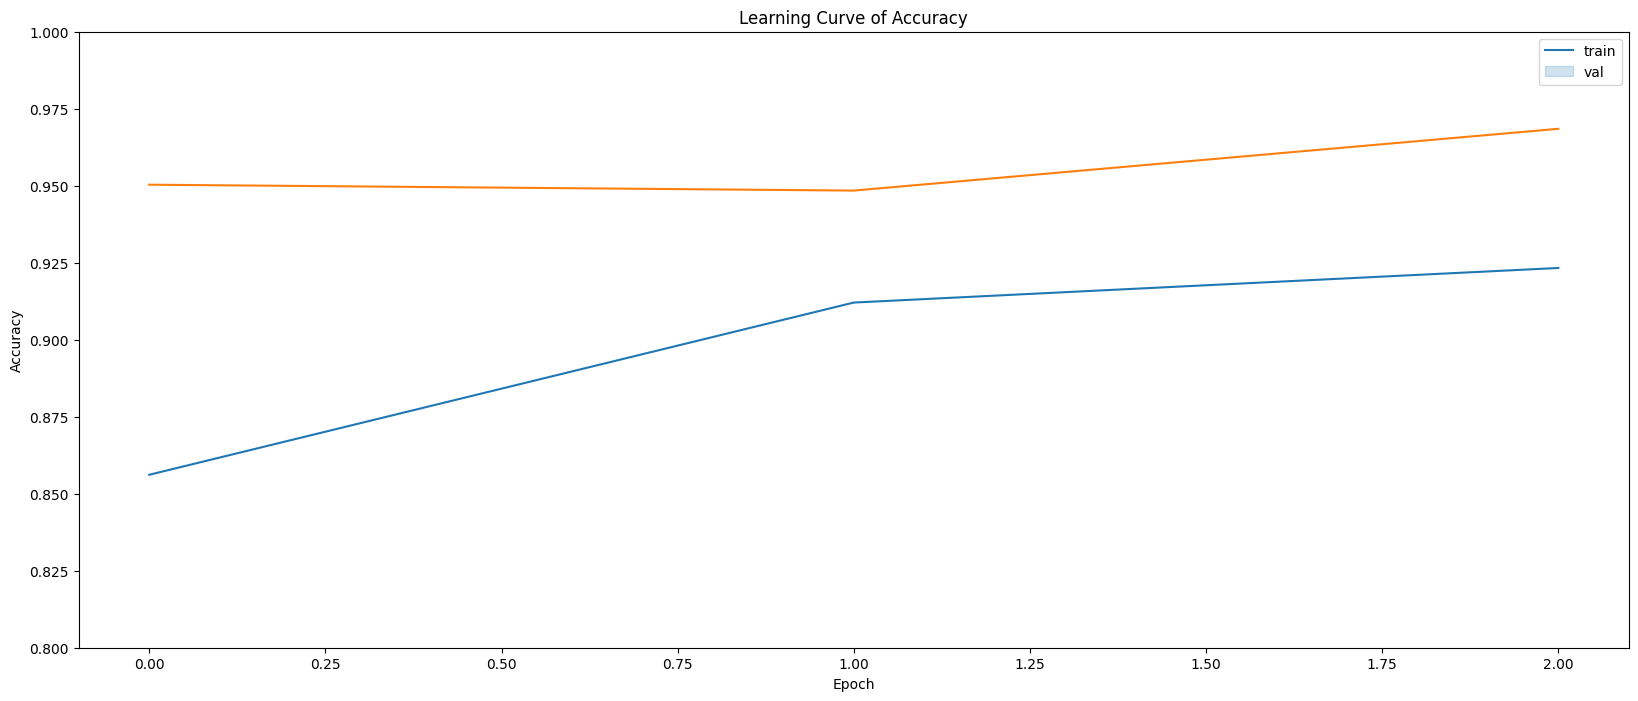

In [17]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = eff_history_tuned.epoch, y = eff_history_tuned.history['accuracy'])
sns.lineplot(x = eff_history_tuned.epoch, y = eff_history_tuned.history['val_accuracy'])
ax.set_title('Learning Curve of Accuracy')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.80, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

**Checking Performance on Validation Set**

In [19]:
score = model.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

# model gave different val_accuracy here because of randomness in the dropout layer, we can introduce a random seed to avoid that and make it reproducible.

Val loss: 0.09715255349874496
Val accuracy: 0.963705837726593


**Checking Performance on Test Set**

In [20]:
score = model.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.15961351990699768
Test accuracy: 0.9342948794364929


**Plotting the confusion matrix and classification report**

In [21]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [22]:
ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

In [23]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9342948717948718


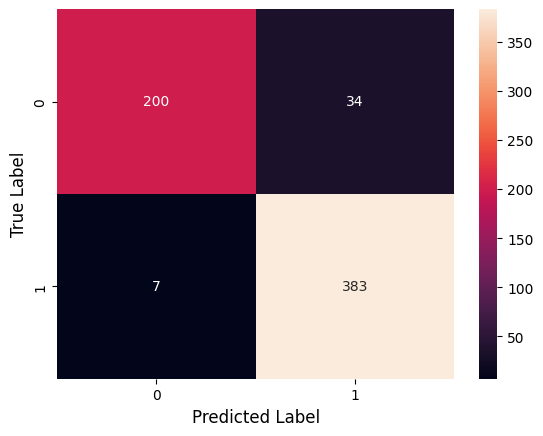

In [24]:
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [25]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       234
           1       0.92      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.92      0.93       624
weighted avg       0.94      0.93      0.93       624



**Saving the model**

In [29]:
model.save('final_model_tuned.h5')

## We notice that our test accuracy after fine-tuning the model decreased and that could be a result of overfitting. However, we had better recall which is our main focus measure. So, we will be going with the fine-tuned model.